In [28]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications import Xception 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# Image folder path

In [29]:
image_path = '/kaggle/input/flickr8kimagescaptions/flickr8k/images'

# Each image has 5 captions, table is loaded from captions.txt file

In [4]:
data = pd.read_csv("/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/kaggle/input/flickr8kimagescaptions/flickr8k/images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

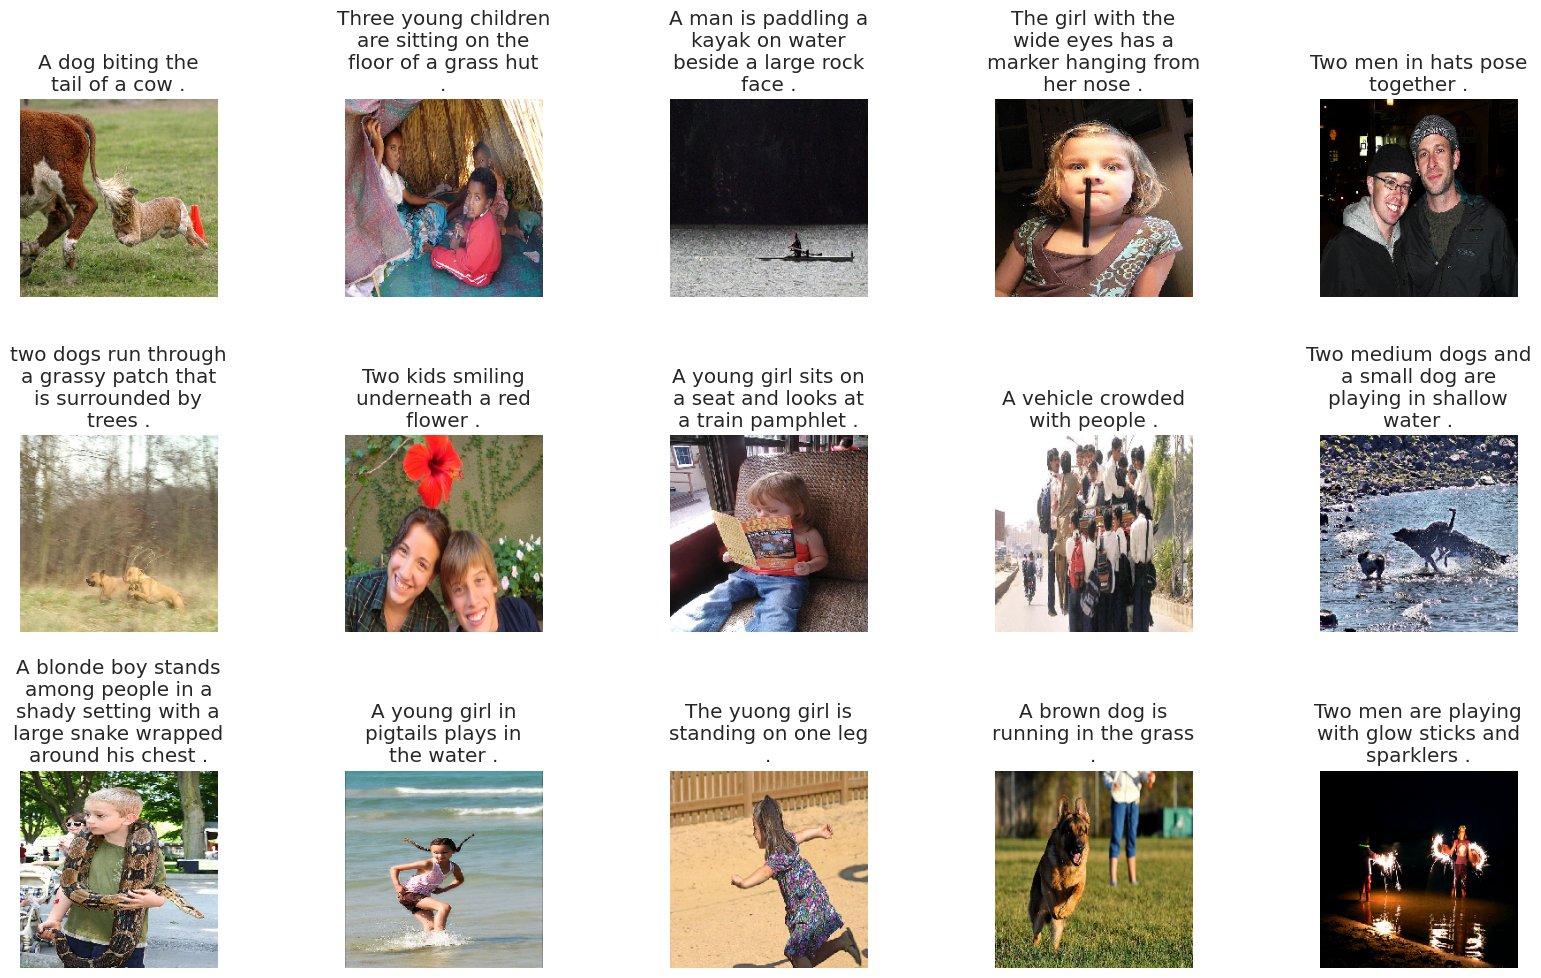

In [6]:
display_images(data.sample(15))


# Captions Pre-Processing

In [7]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [8]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenizing captions

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

## Creating Data Generator 
#### We have to train our model on many images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for these many images is not possible to hold into memory so we will be using a generator method that will yield batches.

#### The generator will yield the input and output sequence.

#### For example:
#### The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.


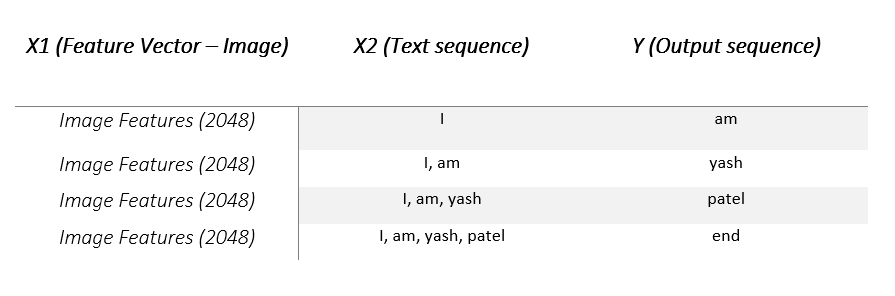
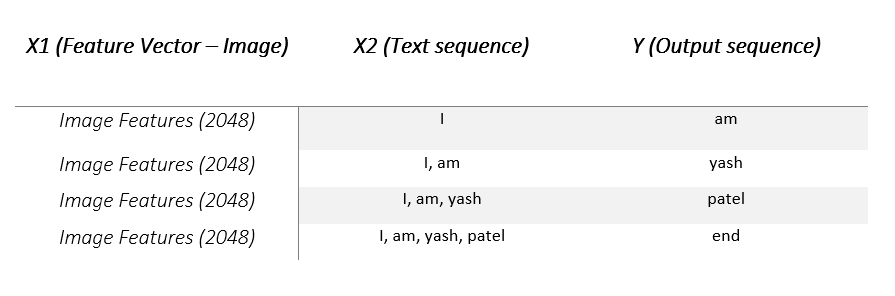

In [10]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

### 🔷 DenseNet201 (Pretrained on ImageNet)

We use **DenseNet201** to extract image features by removing its final classification layers. Input images are resized to **224×224** and passed through the model. Features are taken from the second-last layer, resulting in a **1920-dimensional feature vector** for each image.

---

In [10]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


100%|██████████| 8091/8091 [12:03<00:00, 11.19it/s]


In [13]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [15]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        491,776 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 34, 256)        │      2,172,160 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 35, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [27]:
model_name = "densenet_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

### 🔷 DenseNet Training:
- Extracted features are passed through a dense layer to reduce dimensions to 256.
- Word embeddings and image features are merged and fed into an LSTM.
- Trained for **20 epochs** using `categorical_crossentropy` loss and the **Adam** optimizer.
- Best model saved using `ModelCheckpoint` based on validation loss.

---

In [28]:
# For DenseNet model:
history_densenet = caption_model.fit(
    train_generator,
    epochs=20,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction],
    verbose=1
)

Epoch 1/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - loss: 3.3288 - learning_rate: 0.0010
Epoch 2/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - loss: 3.2848 - learning_rate: 0.0010
Epoch 3/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - loss: 3.2484 - learning_rate: 0.0010
Epoch 4/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - loss: 3.2207 - learning_rate: 0.0010
Epoch 5/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - loss: 3.1800 - learning_rate: 0.0010
Epoch 6/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - loss: 3.1503 - learning_rate: 0.0010
Epoch 7/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - loss: 3.1165 - learning_rate: 0.0010
Epoch 8/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - loss: 3.1063 - learning_rate: 0.0010
Epoch 9/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 65s 119ms/step - loss: 3.0702 - learning_rate: 0.0010
Epoch 10/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - loss: 3.0464 - learning_rate: 0.0010
Epoch 11/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 67s 123ms/step - l

In [29]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], marker='o', label='Training Loss')
    plt.title('Training Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


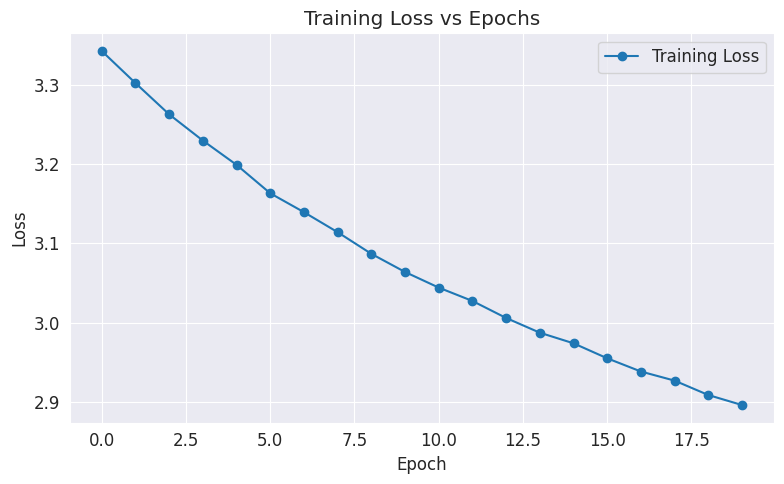

In [31]:
plot_loss(history_densenet)


### 🔶 Xception (Pretrained on ImageNet)

The **Xception** model is also used as a feature extractor. It accepts images of size **299×299×3**. We remove the top classification layer and take the **2048-dimensional** output from the global average pooling layer. This feature vector is then fed into the captioning model.

---

In [17]:
model = Xception(include_top=False, pooling='avg')  # Changed from DenseNet201 to Xception
fe = model

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [18]:


img_size = 299  # Changed from 224 to 299 for Xception
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature


100%|██████████| 8091/8091 [10:04<00:00, 13.39it/s]


In [20]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [19]:
# Changed input shape from 1920 to 2048 for Xception output
input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model1 = Model(inputs=[input1, input2], outputs=output)
caption_model1.compile(loss='categorical_crossentropy', optimizer='adam')

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model1)

caption_model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 256)         │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 34, 256)        │      2,172,160 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 35, 256)        │              0 │ reshape_1[0][0],       │
│ (Concatenate)             │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 256)            │              0 │ dropout_2[0][0],       │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         32,896 │ add_13[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,349,477 (16.59 MB)

 Trainable params: 4,349,477 (16.59 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_name = "xception_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

### 🔶 Xception Training:
- Same architecture as DenseNet model, adapted to accept 2048 input features.
- Captions are tokenized and padded to a fixed max length.
- Trained using `caption_model1` for **20 epochs**, saving best weights with early stopping and learning rate scheduling.

---

In [22]:
history = caption_model1.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 5.7288
Epoch 1: val_loss improved from inf to 4.23411, saving model to xception_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 294s 534ms/step - loss: 5.7275 - val_loss: 4.2341 - learning_rate: 0.0010
Epoch 2/20
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 4.2510
Epoch 2: val_loss improved from 4.23411 to 3.92659, saving model to xception_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - loss: 4.2507 - val_loss: 3.9266 - learning_rate: 0.0010
Epoch 3/20
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 3.9514
Epoch 3: val_loss improved from 3.92659 to 3.79072, saving model to xception_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - loss: 3.9513 - val_loss: 3.7907 - learning_rate: 0.0010
Epoch 4/20
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 3.7827
Epoch 4: val_loss improved from 3.79072 to 3.71834, saving model to xception_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 77s 141ms/step - loss: 3.7826 - val_

In [23]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], marker='o', label='Training Loss')
    plt.title('Training Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


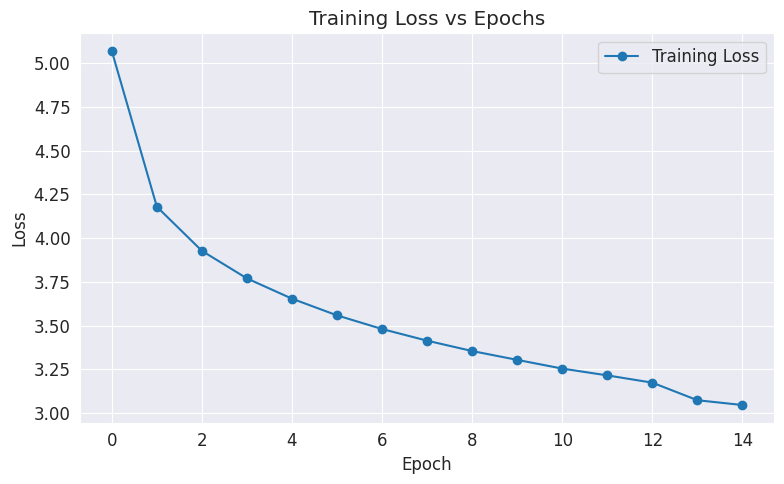

In [24]:
plot_loss(history)

### 🟢 InceptionV3 (Pretrained on ImageNet)

**InceptionV3** is another feature extractor used in our setup. Like Xception, it expects **299×299** input images. We extract the **2048-dimensional features** from the last pooling layer (after removing the top classifier). These features are used to guide the caption generation LSTM network.

---

In [25]:
# Load InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg')
fe = inception_model
img_size = 299  # InceptionV3 requires 299x299 input

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [26]:
# Extract features from all images
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    # Preprocess the image for InceptionV3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [09:35<00:00, 14.06it/s]


In [30]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [31]:
# Build the model with InceptionV3 feature size (2048)
input1 = Input(shape=(2048,))  # InceptionV3 outputs 2048 features
input2 = Input(shape=(max_length,))

# Image feature processing branch
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Text processing branch
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Merge image and text features
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model2 = Model(inputs=[input1, input2], outputs=output)
caption_model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model2)

caption_model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        524,544 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 256)         │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 34, 256)        │      2,172,160 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 35, 256)        │              0 │ reshape_2[0][0],       │
│ (Concatenate)             │                        │                │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 256)            │              0 │ dropout_4[0][0],       │
│                           │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         32,896 │ add_14[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,048,433 (49.78 MB)

 Trainable params: 4,349,477 (16.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,698,956 (33.18 MB)

In [36]:
# Setup callbacks
model_name = "inception_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.00000001
)



### 🟢 InceptionV3 Training:
- Follows the same LSTM decoder pipeline as Xception.
- Training used `caption_model2` with callbacks like `EarlyStopping`, `ModelCheckpoint`, and `ReduceLROnPlateau`.
- The model was compiled with `metrics=['accuracy']` and evaluated using **BLEU score** post-training.

---

In [37]:
# Train the model
history_inception = caption_model2.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)



Epoch 1/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 4.7270
Epoch 1: val_loss improved from inf to 4.26649, saving model to inception_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 287s 528ms/step - loss: 4.7268 - val_loss: 4.2665 - learning_rate: 0.0010
Epoch 2/20
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 4.3128
Epoch 2: val_loss improved from 4.26649 to 4.10081, saving model to inception_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - loss: 4.3127 - val_loss: 4.1008 - learning_rate: 0.0010
Epoch 3/20
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 4.1519
Epoch 3: val_loss improved from 4.10081 to 4.03388, saving model to inception_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 66s 122ms/step - loss: 4.1518 - val_loss: 4.0339 - learning_rate: 0.0010
Epoch 4/20
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 4.0507
Epoch 4: val_loss improved from 4.03388 to 3.96295, saving model to inception_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 75s 138ms/step - loss: 4.0507 - 

In [38]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], marker='o', label='Training Loss')
    plt.title('Training Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


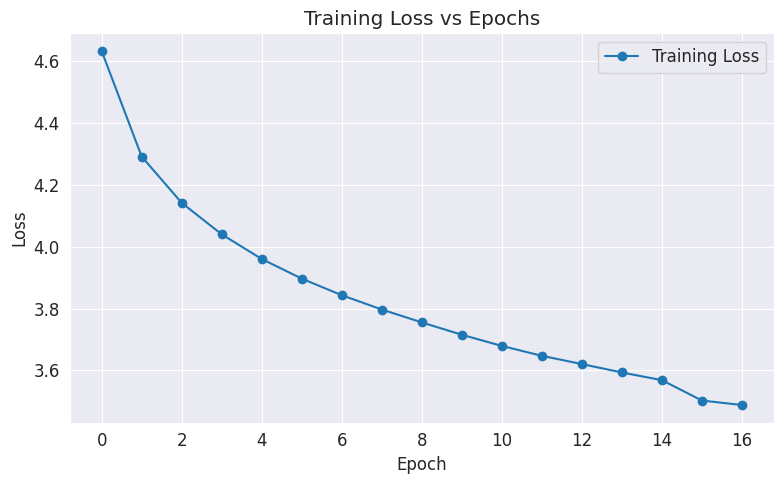

In [39]:
plot_loss(history_inception)

In [40]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [41]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [42]:
import os
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
# Load trained models
caption_model_densenet = load_model('/kaggle/input/dense_net/keras/default/1/densenet_model.keras')
caption_model_xception = load_model('/kaggle/input/xception_model/keras/default/1/xception_model.keras')
caption_model_inception = load_model('/kaggle/input/inception_model/keras/default/1/inception_model.keras')


In [51]:
def evaluate_model_bleu(model, data, tokenizer, max_length, features, sample_limit=100, verbose=False):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

    smooth = SmoothingFunction().method1
    total_bleu = 0

    for idx, row in data.iterrows():
        if idx >= sample_limit:
            break

        image_name = row['image']
        actual_caption = row['caption'].replace("startseq ", "").replace(" endseq", "")
        predicted_caption = predict_caption(model, image_name, tokenizer, max_length, {image_name: features[image_name]})
        predicted_caption = predicted_caption.replace("startseq ", "").replace(" endseq", "")

        reference = [actual_caption.split()]
        candidate = predicted_caption.split()
        score = sentence_bleu(reference, candidate, smoothing_function=smooth)
        total_bleu += score

        # Only show a few examples if verbose=True
        if verbose and idx < 3:
            print(f"\nSample {idx + 1}")
            print("Actual:   ", actual_caption)
            print("Predicted:", predicted_caption)
            print("BLEU Score:", round(score, 4))

    avg_bleu = total_bleu / sample_limit
    if verbose:
        print(f"\n✅ {model.name} - Average BLEU Score: {avg_bleu:.4f}")
    return avg_bleu


In [47]:
# DenseNet201 features
features_dense = {}
fe_dense = DenseNet201(include_top=False, pooling='avg')
for image in tqdm(data['image'].unique()):
    img = load_img(os.path.join(image_path, image), target_size=(224, 224))
    img = img_to_array(img) / 255.
    img = np.expand_dims(img, axis=0)
    features_dense[image] = fe_dense.predict(img, verbose=0)

# Xception features
features_xcept = {}
fe_xcept = Xception(include_top=False, pooling='avg')
for image in tqdm(data['image'].unique()):
    img = load_img(os.path.join(image_path, image), target_size=(299, 299))
    img = img_to_array(img) / 255.
    img = np.expand_dims(img, axis=0)
    features_xcept[image] = fe_xcept.predict(img, verbose=0)

# InceptionV3 features
features_incept = {}
fe_incept = InceptionV3(include_top=False, pooling='avg')
for image in tqdm(data['image'].unique()):
    img = load_img(os.path.join(image_path, image), target_size=(299, 299))
    img = img_to_array(img) / 255.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    features_incept[image] = fe_incept.predict(img, verbose=0)


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


100%|██████████| 8091/8091 [09:52<00:00, 13.66it/s]


In [ ]:
bleu_dense = evaluate_model_bleu(
    model=caption_model_densenet,
    data=test,
    tokenizer=tokenizer,
    max_length=max_length,
    features=features_dense,
    sample_limit=200,  # You can reduce to 50 for quicker test
    verbose=False
)

bleu_xcept = evaluate_model_bleu(
    model=caption_model_xception,
    data=test,
    tokenizer=tokenizer,
    max_length=max_length,
    features=features_xcept,
    sample_limit=200,
    verbose=False
)

bleu_incept = evaluate_model_bleu(
    model=caption_model_inception,
    data=test,
    tokenizer=tokenizer,
    max_length=max_length,
    features=features_incept,
    sample_limit=200,
    verbose=False
)


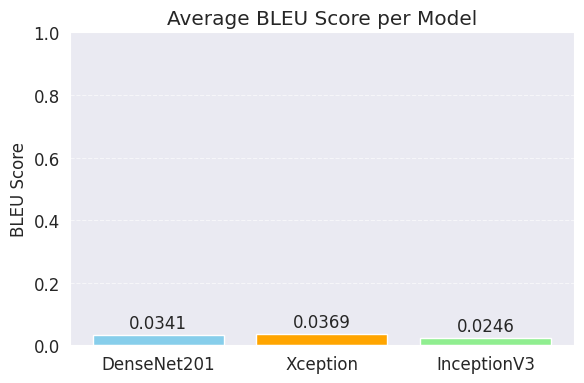

In [55]:
models = ['DenseNet201', 'Xception', 'InceptionV3']
avg_scores = [bleu_dense, bleu_xcept, bleu_incept]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, avg_scores, color=['skyblue', 'orange', 'lightgreen'])
plt.title("Average BLEU Score per Model")
plt.ylabel("BLEU Score")
plt.ylim(0, 1)

# Add score annotations on top of bars
for bar, score in zip(bars, avg_scores):
    plt.text(bar.get_x() + bar.get_width()/2.0, score + 0.02, f"{score:.4f}", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


--------------------- Actual Captions ---------------------
little girl covered in paint sits in front of painted rainbow with her hands in bowl
little girl is sitting in front of large painted rainbow
small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it
there is girl with pigtails sitting in front of rainbow painting
young girl with pigtails painting outside in the grass

--------------------- DenseNet201 Prediction ---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
little girl is playing 

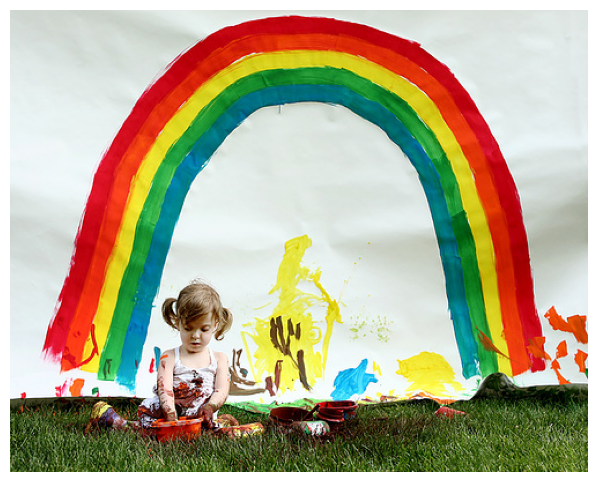

In [61]:
from PIL import Image
# Load your saved trained models
caption_model_densenet = load_model('/kaggle/input/dense_net/keras/default/1/densenet_model.keras')
caption_model_xception = load_model('/kaggle/input/xception_model/keras/default/1/xception_model.keras')
caption_model_inception = load_model('/kaggle/input/inception_model/keras/default/1/inception_model.keras')

# Feature extraction models for each architecture
def get_feature_extractor(model_type):
    if model_type == 'densenet':
        base_model = DenseNet201(include_top=False, pooling='avg')
        img_size = 224
    elif model_type == 'xception':
        base_model = Xception(include_top=False, pooling='avg')
        img_size = 299
    else:  # inception
        base_model = InceptionV3(include_top=False, pooling='avg')
        img_size = 299

    return base_model, img_size

# Extract single image feature
def extract_feature(img_path, base_model, model_type, img_size):
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.
    img = np.expand_dims(img, axis=0)
    if model_type == 'inception':
        img = tf.keras.applications.inception_v3.preprocess_input(img)
    feature = base_model.predict(img, verbose=0)
    return feature

# Display generated captions for each model
def display_captions(image_name):
    img_path = os.path.join(image_path, image_name)
    image = Image.open(img_path)

    base_densenet, size_dense = get_feature_extractor('densenet')
    base_xception, size_xcept = get_feature_extractor('xception')
    base_inception, size_incept = get_feature_extractor('inception')

    feature_dense = extract_feature(img_path, base_densenet, 'densenet', size_dense)
    feature_xcept = extract_feature(img_path, base_xception, 'xception', size_xcept)
    feature_incept = extract_feature(img_path, base_inception, 'inception', size_incept)

    print("--------------------- Actual Captions ---------------------")
    actual_captions = data[data['image'] == image_name]['caption'].tolist()
    for caption in actual_captions:
        print(caption.replace("startseq ", "").replace(" endseq", ""))

    print("\n--------------------- DenseNet201 Prediction ---------------------")
    pred_dense = predict_caption(caption_model_densenet, image_name, tokenizer, max_length, {image_name: feature_dense})
    print(pred_dense.replace("startseq ", "").replace(" endseq", ""))

    print("\n--------------------- Xception Prediction ---------------------")
    pred_xcept = predict_caption(caption_model_xception, image_name, tokenizer, max_length, {image_name: feature_xcept})
    print(pred_xcept.replace("startseq ", "").replace(" endseq", ""))

    print("\n--------------------- InceptionV3 Prediction ---------------------")
    pred_incept = predict_caption(caption_model_inception, image_name, tokenizer, max_length, {image_name: feature_incept})
    print(pred_incept.replace("startseq ", "").replace(" endseq", ""))

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example call to display generated captions for a specific image
display_captions("1002674143_1b742ab4b8.jpg")


--------------------- Actual Captions ---------------------
black and white dog is running in grassy garden surrounded by white fence
black and white dog is running through the grass
boston terrier is running in the grass
boston terrier is running on lush green grass in front of white fence
dog runs on the green grass near wooden fence

--------------------- DenseNet201 Prediction ---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
dog is running through the grass

--------------------- Xception Prediction ---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


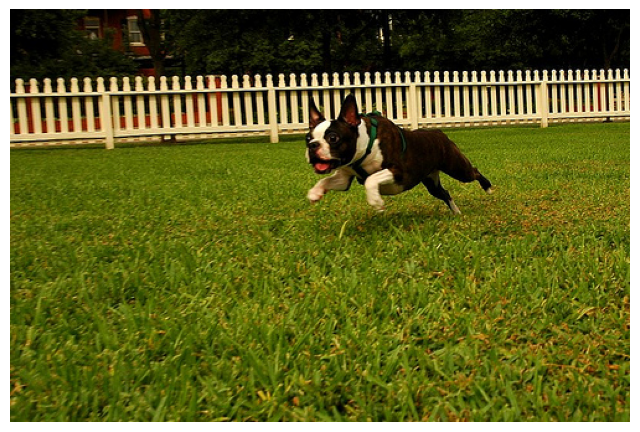

In [63]:
# Load your saved trained models
caption_model_densenet = load_model('/kaggle/input/dense_net/keras/default/1/densenet_model.keras')
caption_model_xception = load_model('/kaggle/input/xception_model/keras/default/1/xception_model.keras')
caption_model_inception = load_model('/kaggle/input/inception_model/keras/default/1/inception_model.keras')

# Feature extraction models for each architecture
def get_feature_extractor(model_type):
    if model_type == 'densenet':
        base_model = DenseNet201(include_top=False, pooling='avg')
        img_size = 224
    elif model_type == 'xception':
        base_model = Xception(include_top=False, pooling='avg')
        img_size = 299
    else:  # inception
        base_model = InceptionV3(include_top=False, pooling='avg')
        img_size = 299

    return base_model, img_size

# Extract single image feature
def extract_feature(img_path, base_model, model_type, img_size):
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.
    img = np.expand_dims(img, axis=0)
    if model_type == 'inception':
        img = tf.keras.applications.inception_v3.preprocess_input(img)
    feature = base_model.predict(img, verbose=0)
    return feature

# Display generated captions for each model
def display_captions(image_name):
    img_path = os.path.join(image_path, image_name)
    image = Image.open(img_path)

    base_densenet, size_dense = get_feature_extractor('densenet')
    base_xception, size_xcept = get_feature_extractor('xception')
    base_inception, size_incept = get_feature_extractor('inception')

    feature_dense = extract_feature(img_path, base_densenet, 'densenet', size_dense)
    feature_xcept = extract_feature(img_path, base_xception, 'xception', size_xcept)
    feature_incept = extract_feature(img_path, base_inception, 'inception', size_incept)

    print("--------------------- Actual Captions ---------------------")
    actual_captions = data[data['image'] == image_name]['caption'].tolist()
    for caption in actual_captions:
        print(caption.replace("startseq ", "").replace(" endseq", ""))

    print("\n--------------------- DenseNet201 Prediction ---------------------")
    pred_dense = predict_caption(caption_model_densenet, image_name, tokenizer, max_length, {image_name: feature_dense})
    print(pred_dense.replace("startseq ", "").replace(" endseq", ""))

    print("\n--------------------- Xception Prediction ---------------------")
    pred_xcept = predict_caption(caption_model_xception, image_name, tokenizer, max_length, {image_name: feature_xcept})
    print(pred_xcept.replace("startseq ", "").replace(" endseq", ""))

    print("\n--------------------- InceptionV3 Prediction ---------------------")
    pred_incept = predict_caption(caption_model_inception, image_name, tokenizer, max_length, {image_name: feature_incept})
    print(pred_incept.replace("startseq ", "").replace(" endseq", ""))

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example call to display generated captions for a specific image
display_captions("1009434119_febe49276a.jpg")


--------------------- Actual Captions ---------------------
collage of one person climbing cliff
group of people are rock climbing on rock climbing wall
group of people climbing rock while one man belays
seven climbers are ascending rock face whilst another man stands holding the rope
several climbers in row are climbing the rock while the man in red watches and holds the line
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

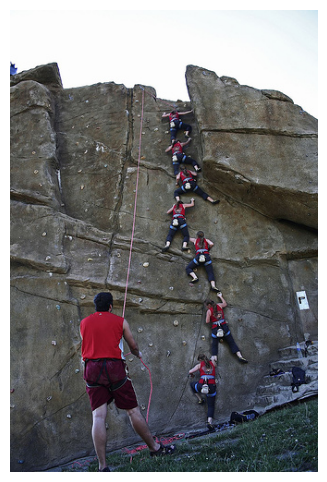

In [65]:
from nltk.translate.bleu_score import sentence_bleu

# Function to calculate BLEU score
def calculate_bleu(reference_captions, candidate_caption):
    reference_tokens = [caption.replace("startseq", "").replace("endseq", "").split() for caption in reference_captions]
    candidate_tokens = candidate_caption.replace("startseq", "").replace("endseq", "").split()
    return sentence_bleu(reference_tokens, candidate_tokens)

# Display generated captions and BLEU scores for each model
def display_captions(image_name):
    img_path = os.path.join(image_path, image_name)
    image = Image.open(img_path)

    base_densenet, size_dense = get_feature_extractor('densenet')
    base_xception, size_xcept = get_feature_extractor('xception')
    base_inception, size_incept = get_feature_extractor('inception')

    feature_dense = extract_feature(img_path, base_densenet, 'densenet', size_dense)
    feature_xcept = extract_feature(img_path, base_xception, 'xception', size_xcept)
    feature_incept = extract_feature(img_path, base_inception, 'inception', size_incept)

    print("--------------------- Actual Captions ---------------------")
    actual_captions = data[data['image'] == image_name]['caption'].tolist()
    for caption in actual_captions:
        print(caption.replace("startseq ", "").replace(" endseq", ""))

    pred_dense = predict_caption(caption_model_densenet, image_name, tokenizer, max_length, {image_name: feature_dense})
    pred_xcept = predict_caption(caption_model_xception, image_name, tokenizer, max_length, {image_name: feature_xcept})
    pred_incept = predict_caption(caption_model_inception, image_name, tokenizer, max_length, {image_name: feature_incept})

    print("\nDenseNet201 Prediction: ", pred_dense.replace("startseq ", "").replace(" endseq", ""))
    print("DenseNet201 BLEU Score: ", calculate_bleu(actual_captions, pred_dense))

    print("\nXception Prediction: ", pred_xcept.replace("startseq ", "").replace(" endseq", ""))
    print("Xception BLEU Score: ", calculate_bleu(actual_captions, pred_xcept))

    print("\nInceptionV3 Prediction: ", pred_incept.replace("startseq ", "").replace(" endseq", ""))
    print("InceptionV3 BLEU Score: ", calculate_bleu(actual_captions, pred_incept))

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example call to display generated captions for a specific image
display_captions("1016887272_03199f49c4.jpg")

--------------------- Actual Captions ---------------------
black and white dog is running in grassy garden surrounded by white fence
black and white dog is running through the grass
boston terrier is running in the grass
boston terrier is running on lush green grass in front of white fence
dog runs on the green grass near wooden fence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━

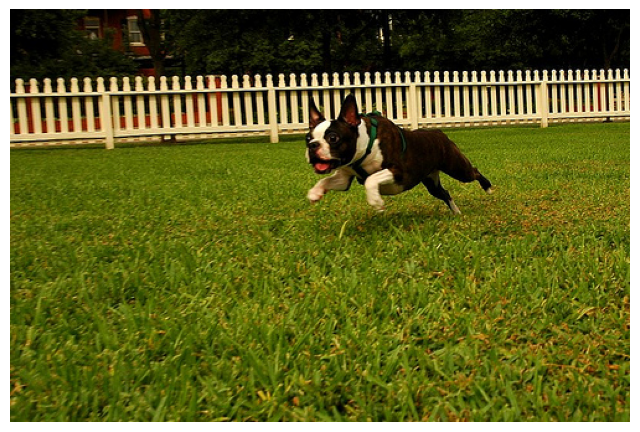

In [66]:
from nltk.translate.bleu_score import sentence_bleu

# Function to calculate BLEU score
def calculate_bleu(reference_captions, candidate_caption):
    reference_tokens = [caption.replace("startseq", "").replace("endseq", "").split() for caption in reference_captions]
    candidate_tokens = candidate_caption.replace("startseq", "").replace("endseq", "").split()
    return sentence_bleu(reference_tokens, candidate_tokens)

# Display generated captions and BLEU scores for each model
def display_captions(image_name):
    img_path = os.path.join(image_path, image_name)
    image = Image.open(img_path)

    base_densenet, size_dense = get_feature_extractor('densenet')
    base_xception, size_xcept = get_feature_extractor('xception')
    base_inception, size_incept = get_feature_extractor('inception')

    feature_dense = extract_feature(img_path, base_densenet, 'densenet', size_dense)
    feature_xcept = extract_feature(img_path, base_xception, 'xception', size_xcept)
    feature_incept = extract_feature(img_path, base_inception, 'inception', size_incept)

    print("--------------------- Actual Captions ---------------------")
    actual_captions = data[data['image'] == image_name]['caption'].tolist()
    for caption in actual_captions:
        print(caption.replace("startseq ", "").replace(" endseq", ""))

    pred_dense = predict_caption(caption_model_densenet, image_name, tokenizer, max_length, {image_name: feature_dense})
    pred_xcept = predict_caption(caption_model_xception, image_name, tokenizer, max_length, {image_name: feature_xcept})
    pred_incept = predict_caption(caption_model_inception, image_name, tokenizer, max_length, {image_name: feature_incept})

    print("\nDenseNet201 Prediction: ", pred_dense.replace("startseq ", "").replace(" endseq", ""))
    print("DenseNet201 BLEU Score: ", calculate_bleu(actual_captions, pred_dense))

    print("\nXception Prediction: ", pred_xcept.replace("startseq ", "").replace(" endseq", ""))
    print("Xception BLEU Score: ", calculate_bleu(actual_captions, pred_xcept))

    print("\nInceptionV3 Prediction: ", pred_incept.replace("startseq ", "").replace(" endseq", ""))
    print("InceptionV3 BLEU Score: ", calculate_bleu(actual_captions, pred_incept))

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example call to display generated captions for a specific image
display_captions("1009434119_febe49276a.jpg")